# ID-Conditioned Transformer Autoencoder (IDC-TransAE) for Anomalous Sound Detection

## Overview

This notebook implements and evaluates an **ID-Conditioned Transformer Autoencoder (IDC-TransAE)** for **unsupervised anomalous sound detection (ASD)**.  
The goal is to learn what *normal* machine sounds look like, and then detect sounds that deviate from this learned normality.

We follow the standard formulation of DCASE Task 2 (Anomalous Sound Detection for Industrial Machines), where only **normal recordings** are available for training, and the model must identify **anomalous recordings** during testing.

IDC-TransAE is a recent Transformer-based ASD model that combines:
1. **Context-based reconstruction** – predicting the *center frame* of a spectrogram patch from its surrounding frames.  
2. **Machine-ID conditioning** – guiding the model to learn *machine-specific* patterns by embedding the machine identity into the Transformer.  
3. **Dual-task learning** – reconstructing the center frame and simultaneously predicting the machine ID.

The intuition:
- Normal machine sounds are structurally consistent → center-frame prediction is accurate → **low reconstruction error**.
- Anomalous sounds disrupt this structure → center-frame prediction becomes harder → **high reconstruction error**.

We therefore use the **center-frame reconstruction MSE** as the anomaly score.

---

## Dataset

We use the [**DCASE 2020 Task 2 (MIMII)**](https://dcase.community/challenge2025/index) dataset, which includes six machine types:

- Fan  
- Pump  
- Slider  
- Valve  
- ToyCar  
- ToyConveyor  

Each machine type contains multiple *machine IDs* (different physical units).  
Each ID has recordings labeled as either:
- **normal**
- **anomaly** (test set only)

In this notebook, we focus on **one machine type (fan)** and use:
- **Normal training recordings** → training the IDC-TransAE  
- **Normal and anomalous test recordings** → evaluating anomaly scores

---

## Why IDC-TransAE?

Traditional autoencoders reconstruct the entire spectrogram and often fail to distinguish subtle anomalies, because they can learn to reproduce anomalies as well as normal data.

IDC-TransAE improves on this by:
- **masking the center frame** (forcing a prediction task)  
- **using Transformer self-attention** (stronger context modeling)  
- **conditioning on machine ID** (each ID has its own acoustic signature)

This often leads to better anomaly detection performance than standard CNN autoencoders or interpolative MLPs.

## Reference

The IDC-TransAE model implemented in this notebook is based on the following paper:

**Mukae, Kazuki; Koizumi, Yuma; Tanabe, Ryo; Harada, Tomoya; Kawaguchi, Yuki; Nikaido, Yasunori.**  
*“ID-Conditioned Autoencoder-Based Transformer for Anomalous Sound Detection.”*  
DCASE Workshop 2022.  
Available at: https://arxiv.org/pdf/2310.08950


In [1]:
import os
from pathlib import Path
import random

import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Path to the dataset (relative to the notebook)
DATA_ROOT = Path("../data")
MACHINE_TYPES = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]

# Audio and feature configuration
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# Patch configuration
PATCH_FRAMES = 64      # number of time frames per patch
PATCH_HOP = 32         # hop size between consecutive patches (for sliding windows)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device("cuda")
else:
    print("CUDA not available, falling back to CPU.")
    device = torch.device("cpu")

print("Using device:", device)

PyTorch version: 2.9.1+cu126
CUDA available: True
Number of CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


### Scanning the dataset folder

This code searches through the `../data` directory and builds a list of all audio files.
For every `.wav` file, it records:

- the file path  
- the machine type (fan, pump, slider, etc.)  
- whether it belongs to the training or test split  
- a label:  
  - `0` for normal  
  - `1` for anomaly  
  - `None` if the filename does not specify this

The result is a list that we can use to build datasets later.

In [2]:
def scan_files(data_root=DATA_ROOT, machine_types=None):
    """
    Scan ../data and return a list of dictionaries containing:
    {
        'path': Path,
        'machine_type': str,
        'split': 'train' or 'test',
        'label': 0 (normal) or 1 (anomaly)
    }
    """
    if machine_types is None:
        machine_types = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]

    all_files = []

    for mtype in machine_types:
        for split in ["train", "test"]:
            split_dir = data_root / mtype / split
            if not split_dir.exists():
                continue

            for fname in sorted(split_dir.glob("*.wav")):
                name_lower = fname.name.lower()

                if "normal" in name_lower:
                    label = 0
                elif "anomaly" in name_lower:
                    label = 1
                else:
                    # fallback if the filename does not explicitly specify the class
                    label = None

                all_files.append({
                    "path": fname,
                    "machine_type": mtype,
                    "split": split,
                    "label": label,
                })

    return all_files


file_list = scan_files()
len(file_list), file_list[:5]

(30987,
 [{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0}])

### Loading audio and converting it to a log-Mel spectrogram

This code defines two helper functions:

1. `load_audio(path)`  
   - Loads an audio file using librosa.  
   - Converts it to mono and resamples it to the chosen sample rate.

2. `audio_to_logmelspec(y)`  
   - Converts the waveform into a Mel spectrogram.  
   - Applies a logarithm to compress the dynamic range.  
   - Returns a 2D array with shape `(n_mels, n_frames)`.

These functions prepare the raw audio so that it can be used as input for the neural network.

In [3]:
def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio file as mono at a fixed sample rate.

    Returns:
        audio: np.ndarray, shape (samples,)
        sr   : int, sample rate
    """
    audio, sr = librosa.load(path, sr=sr, mono=True)
    return audio, sr


def audio_to_logmelspec(
    audio,
    sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
):
    """
    Convert a waveform into a log-Mel spectrogram.
    audio : 1D numpy array
    sr    : sample rate

    Returns:
        log-Mel spectrogram of shape (n_mels, n_frames)
    """
    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    logS = np.log(S + 1e-12)
    return logS

### Splitting a spectrogram into patches and preparing batches

This code performs two tasks:

1. `spec_to_patches(spec)`  
   - Takes a full log-Mel spectrogram.  
   - Splits it into smaller segments (patches) with a fixed number of time frames.  
   - Uses a sliding window so patches can overlap.  
   - Returns an array of shape `(num_patches, n_mels, patch_frames)`.

2. `collate_patches_with_meta(batch)`  
   - Custom DataLoader collate function.  
   - Combines all patch tensors in a batch into one tensor.  
   - Keeps metadata dictionaries as a separate list (not merged).  
   - This avoids errors because PyTorch cannot automatically collate dictionaries with Path objects.

These functions prepare spectrogram data so it can be fed efficiently into the neural network during training.


In [4]:
def spec_to_patches(spec, patch_frames=PATCH_FRAMES, patch_hop=PATCH_HOP):
    """
    Convert a spectrogram into overlapping patches.

    Parameters:
        spec : np.array of shape (n_mels, n_frames)
        patch_frames : number of time frames per patch
        patch_hop : hop size between consecutive patches

    Returns:
        np.array of shape (n_patches, n_mels, patch_frames)
    """
    n_mels, n_frames = spec.shape

    # If the spectrogram is shorter than the required patch length, pad it with zeros
    if n_frames < patch_frames:
        pad_width = patch_frames - n_frames
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
        n_frames = spec.shape[1]

    patches = []
    for start in range(0, n_frames - patch_frames + 1, patch_hop):
        end = start + patch_frames
        patch = spec[:, start:end]
        patches.append(patch)

    patches = np.stack(patches, axis=0)
    return patches


def collate_patches_with_meta(batch):
    """
    Custom collate function for DataLoader.

    Parameters:
        batch : list of (patch_tensor, meta_dict)

    Returns:
        patches : tensor of shape [B, 1, n_mels, patch_frames]
        metas   : tuple or list of metadata dictionaries (not collated)
    """
    patches, metas = zip(*batch)
    patches = torch.stack(patches, dim=0)
    return patches, metas

## DCASETrainPatchDataset - Training Patch Dataset

The `DCASETrainPatchDataset` is a custom PyTorch dataset used to prepare training data for the IDC-TransAE model.  
It follows the standard setup of DCASE Task 2, where **only normal recordings** are used for training.

### What this dataset does

For each item in the dataset:

1. **Select only normal training files**  
   The dataset filters the file list so that it contains only:
   - `split == "train"`
   - `label == 0` (normal)

2. **Optionally filter by machine type**  
   Example: only use `fan` recordings.

3. **File-level train/validation split**  
   A fixed portion (default 20%) is used for the validation dataset.

4. **Load audio and convert it to log-Mel spectrogram**  
   Every audio file is transformed into a spectrogram representation.

5. **Split the spectrogram into overlapping patches**  
   Each patch contains a fixed number of frames (e.g., 64 frames).

6. **Randomly select one patch per file**  
   Each call to `__getitem__` returns a *different* patch, increasing training variety.

7. **Patch normalization**  
   During initialization, the mean and standard deviation are computed over all patches in the training set.  
   These statistics are then applied to normalize each patch.

8. **Return a training sample**  
   The output is:
   - a normalized patch tensor of shape **(1, n_mels, patch_frames)**  
   - a metadata dictionary describing the audio file

In [5]:
class DCASETrainPatchDataset(Dataset):
    """
    Dataset used to train the autoencoder.

    It uses only normal training files (split == 'train' and label == 0).

    For each item:
        - load the audio file,
        - compute the log-Mel spectrogram,
        - split it into patches,
        - randomly select one patch,
        - return it along with metadata.
    """

    def __init__(
        self,
        file_list,
        machine_type=None,
        val_split=0.2,
        split="train",      # 'train' or 'val'
        normalize=True,
    ):
        # Select only normal training files
        candidates = [
            f for f in file_list
            if f["split"] == "train" and f["label"] == 0
        ]

        # Optional: filter by machine type
        if machine_type is not None:
            candidates = [
                f for f in candidates
                if f["machine_type"] == machine_type
            ]

        # Train/validation split at the file level
        random.shuffle(candidates)
        n_total = len(candidates)
        n_val = int(n_total * val_split)

        val_files = candidates[:n_val]
        train_files = candidates[n_val:]

        if split == "train":
            self.files = train_files
        elif split == "val":
            self.files = val_files
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.normalize = normalize

        # Normalization statistics (mean and standard deviation)
        self.mean_ = 0.0
        self.std_ = 1.0

        # Fit normalization on the training set only
        if normalize and split == "train":
            self._fit_normalization(train_files)

    def _fit_normalization(self, files_subset):
        """
        Compute an approximate mean and standard deviation over all patches
        in a subset of training files. This is sufficient for a first version.
        """
        print("Fitting normalization (mean/std) over a subset of training data...")
        values = []

        for f in files_subset:
            # UNPACK audio and sr
            audio, sr = load_audio(f["path"])
            # Pas deze call aan als jouw functie andere args verwacht
            spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
            # idem: gebruik jouw eigen signatuur van spec_to_patches
            patches = spec_to_patches(
                spec,
                patch_frames=PATCH_FRAMES,
                patch_hop=PATCH_HOP,
            )

            # Flatten patches and collect values
            values.append(patches.reshape(-1))

        values = np.concatenate(values, axis=0)
        self.mean_ = float(values.mean())
        self.std_ = float(values.std() + 1e-6)

        print(f"mean={self.mean_:.4f}, std={self.std_:.4f}")

    def __len__(self):
        # Each file corresponds to one dataset element, but each call returns a different random patch
        return len(self.files)

    def __getitem__(self, idx):
        meta = self.files[idx]

        # UNPACK audio and sr
        audio, sr = load_audio(meta["path"])
        spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
        patches = spec_to_patches(
            spec,
            patch_frames=PATCH_FRAMES,
            patch_hop=PATCH_HOP,
        )

        # Randomly select a patch
        if patches.shape[0] == 0:
            # fallback: leeg audio → dummy patch
            patch = np.zeros((N_MELS, PATCH_FRAMES), dtype=np.float32)
        else:
            p_idx = np.random.randint(0, patches.shape[0])
            patch = patches[p_idx]  # verwacht vorm (N_MELS, PATCH_FRAMES)

        # Normalize if enabled
        if self.normalize:
            patch = (patch - self.mean_) / (self.std_ + 1e-8)

        # Convert to tensor with shape (1, n_mels, patch_frames)
        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)

        return patch_tensor, meta

In [6]:
train_dataset_fan = DCASETrainPatchDataset(file_list, machine_type="fan", split="train")
val_dataset_fan = DCASETrainPatchDataset(file_list, machine_type="fan", split="val",
                                     normalize=train_dataset_fan.normalize)

Fitting normalization (mean/std) over a subset of training data...
mean=-6.9173, std=2.0605


### Creating DataLoaders

The validation dataset must use the **same normalization statistics** (mean and standard deviation) as the training dataset.  
We copy these values to ensure both datasets are represented in the same feature space.

We then create two PyTorch `DataLoader` objects:
- a shuffled loader for **training**  
- a deterministic loader for **validation**

Both loaders use a custom `collate_fn` so that:
- patch tensors are batched together
- metadata dictionaries are kept unmodified

In [7]:
# Copy mean and standard deviation from the training dataset to the validation dataset
val_dataset_fan.mean_ = train_dataset_fan.mean_
val_dataset_fan.std_ = train_dataset_fan.std_

# DataLoader for training
train_loader = DataLoader(
    train_dataset_fan,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_patches_with_meta,
)

# DataLoader for validation
val_loader = DataLoader(
    val_dataset_fan,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)

### DCASETestPatchDataset - Test Patch Dataset

This dataset is the test-time counterpart of `DCASETrainPatchDataset`.  
The structure is similar, but with two key differences:

1. **It loads only test recordings**, both normal (`label = 0`) and anomalous (`label = 1`).  
   These labels are preserved in the metadata so the evaluation code can compute anomaly scores.

2. **It does not compute its own normalization statistics.**  
   Instead, it uses the mean and standard deviation learned from the training set to ensure consistent preprocessing.

For each test file, the dataset:
- loads the audio and converts it to a log-Mel spectrogram,  
- extracts all patches,  
- selects one random patch,  
- normalizes it using the training statistics, and  
- returns `(patch_tensor, metadata)`.

This allows the model to evaluate many different patches from each test recording while keeping the process consistent with training.

In [8]:
class DCASETestPatchDataset(Dataset):
    """
    Dataset for evaluating the autoencoder on test data.

    Each item returns:
        - one random spectrogram patch (tensor of shape (1, n_mels, patch_frames)),
        - metadata dict including 'label'.
    """
    def __init__(
        self,
        file_list,
        machine_type=None,
        normalize=True,
        mean_=0.0,
        std_=1.0,
    ):
        # Select test files with valid labels
        self.files = [
            f for f in file_list
            if f["split"] == "test" and f["label"] is not None
        ]

        if machine_type is not None:
            self.files = [
                f for f in self.files
                if f["machine_type"] == machine_type
            ]

        self.normalize = normalize
        self.mean_ = mean_
        self.std_ = std_

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        info = self.files[idx]
        path = info["path"]
        label = info["label"]     # 0 or 1

        # Load audio + spectrogram
        audio, sr = load_audio(path)
        spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
        patches = spec_to_patches(
            spec,
            patch_frames=PATCH_FRAMES,
            patch_hop=PATCH_HOP,
        )

        # Choose one random patch (or fallback to zeros)
        if patches.shape[0] == 0:
            patch = np.zeros((N_MELS, PATCH_FRAMES), dtype=np.float32)
        else:
            i = np.random.randint(0, patches.shape[0])
            patch = patches[i]  # (n_mels, patch_frames)

        # Normalize
        if self.normalize:
            patch = (patch - self.mean_) / (self.std_ + 1e-8)

        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)  # (1, n_mels, T)

        meta = {
            "path": str(path),
            "machine_type": info["machine_type"],
            "split": info["split"],
            "label": int(label),
            "machine_id": info.get("machine_id", None),
        }

        # BELANGRIJK: alleen (patch_tensor, meta), GEEN losse label meer
        return patch_tensor, meta

In [9]:
# Test dataset (fan only, normalized with train mean/std)
test_dataset_fan = DCASETestPatchDataset(
    file_list,
    machine_type="fan",
    normalize=True,
    mean_=train_dataset_fan.mean_,
    std_=train_dataset_fan.std_,
)

test_loader_fan = DataLoader(
    test_dataset_fan,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)

### Adding machine IDs

The IDC-TransAE requires the machine ID for each recording so it can learn machine-specific patterns.   DCASE filenames include this ID (e.g., `fan_id_00_00000000.wav`), so this helper function extracts the number after `id_` and stores it as `machine_id` inside each metadata dictionary. Files without a valid ID receive `None`.  

In [10]:
import re

def add_machine_ids(file_list):
    """
    Add a 'machine_id' integer to each file dict, parsed from the filename.

    Assumes DCASE-style filenames like: fan_id_00_00000000.wav
    => machine_id = 0 (from 'id_00')
    """
    for item in file_list:
        name = item["path"].name  # e.g. fan_id_00_00000000.wav
        m = re.search(r"id_(\d+)", name)
        if m:
            item["machine_id"] = int(m.group(1))
        else:
            item["machine_id"] = None
    return file_list


# Run the function immediately
file_list = add_machine_ids(file_list)

# Quick sanity check
[file_list[i] for i in range(5)]

[{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0}]

### Converting patches to time–frame sequences

The Transformer expects input in the shape `(batch, time, features)`, where each time step corresponds to one spectrogram frame.  
However, our patches come from the CNN-style format `(batch, 1, n_mels, patch_frames)`.

The `patches_to_sequence` helper rearranges the dimensions so that a patch becomes a sequence of frames:

- each column in the patch becomes one time step  
- each time step contains all Mel-frequency bins  

The result is a tensor of shape `(B, T, n_mels)`, which is the required input format for the Transformer.  
The second helper, `get_center_index`, returns the index of the center frame in the sequence so the model knows which frame should be reconstructed.

In [11]:
def patches_to_sequence(patches):
    """
    Convert patches from CNN format to (B, T, F) = (batch, time, n_mels).

    Expected input shapes:
      - (B, 1, n_mels, patch_frames)
      - or (B, n_mels, patch_frames)

    Returns:
      - (B, T, F) where T = patch_frames, F = n_mels
    """
    if patches.dim() == 4:
        # (B, 1, n_mels, patch_frames)
        B, C, F, T = patches.shape
        if C != 1:
            raise ValueError(f"Expected C=1, got {C}")
        x = patches.squeeze(1)          # (B, n_mels, T)
        x = x.permute(0, 2, 1)          # (B, T, n_mels)
        return x
    elif patches.dim() == 3:
        # (B, n_mels, patch_frames)
        x = patches.permute(0, 2, 1)    # (B, T, n_mels)
        return x
    else:
        raise ValueError(f"Unexpected patch shape: {patches.shape}")


def get_center_index(num_frames: int) -> int:
    """
    Return center time index given T frames.
    Uses floor(T / 2).
    """
    return num_frames // 2


# Quick test: run the helpers on a dummy batch
dummy = torch.randn(4, 1, N_MELS, PATCH_FRAMES)
seq = patches_to_sequence(dummy)       # should be (4, PATCH_FRAMES, N_MELS)
print("dummy shape:", dummy.shape)
print("seq shape:", seq.shape)
print("center index:", get_center_index(seq.shape[1]))


dummy shape: torch.Size([4, 1, 128, 64])
seq shape: torch.Size([4, 64, 128])
center index: 32


In [12]:
def get_num_machines_for_type(file_list, machine_type="fan"):
    """
    Compute number of distinct machine IDs for a given machine type.
    """
    ids = sorted({
        f["machine_id"]
        for f in file_list
        if f["machine_type"] == machine_type and f.get("machine_id") is not None
    })
    if not ids:
        raise ValueError(f"No machine_id found for type {machine_type}")
    return max(ids) + 1


NUM_MACHINES_FAN = get_num_machines_for_type(file_list, machine_type="fan")
NUM_MACHINES_FAN

7

### IDCTransAE - ID-Conditioned Transformer Autoencoder

This class defines the core model used in this notebook: an **ID-conditioned Transformer autoencoder** that predicts the **center frame** of a spectrogram patch.

At a high level, the model does three things:

1. It looks at a short window of sound (a patch of the log-Mel spectrogram).  
2. It **hides the center frame** of that patch.  
3. It uses a Transformer to **predict what the hidden frame should look like**, given:
   - the surrounding frames (context in time)
   - the **machine ID** (which physical machine produced the sound)

The idea is: if the sound is *normal* for that machine, the model can easily guess the missing center frame.  
If the sound is *abnormal*, the prediction will be poor and the error will be higher.

---

#### Main parts of the model

- **Frame embedding**  
  Each time frame (a vector of `n_mels` values) is passed through a linear layer to create a higher-dimensional representation (`d_model`).  
  This is similar to turning each frame into a “token” the Transformer can work with.

- **Positional embedding**  
  The model also needs to know **where in time** each frame is.  
  A positional embedding is added to each frame so the Transformer can distinguish “early” vs “late” frames in the patch.

- **Machine-ID embedding**  
  Each physical machine (id_00, id_01, …) has its own learned embedding.  
  This embedding is added to every frame in the patch, so the model is explicitly conditioned on *which machine* produced the sound.  
  This helps the model learn what is “normal” for each specific machine.

- **Transformer encoder**  
  The combined embeddings (frame + position + machine ID) are fed into a Transformer encoder.  
  The Transformer uses self-attention to let each frame look at all other frames in the patch, capturing patterns over time.

- **Center latent vector**  
  After the Transformer, we take the hidden representation at the **center time index**.  
  This vector summarizes the context around the center frame, plus the machine ID.

- **Reconstruction head**  
  A small feed-forward network (MLP) takes the center latent vector and predicts the **center-frame spectrum** (`recon_center`).  
  This is the model’s “best guess” of what the hidden center frame should be.

- **ID-classification head**  
  A second MLP takes the same center latent vector and predicts **which machine ID** produced the patch (`id_logits`).  
  This extra task encourages the model to learn machine-specific structure instead of only a generic “average machine”.

---

#### Forward pass and patch errors

The `forward` method expects:

- `patches`: a batch of spectrogram patches with shape `(B, 1, n_mels, patch_frames)`  
- `machine_ids`: a tensor of machine IDs for each patch

Inside `forward`:

1. The patches are reshaped into sequences `(B, T, n_mels)`, where `T = patch_frames`.  
2. The **center frame is masked to zero**, so the model cannot cheat by looking at it.  
3. The Transformer processes the sequence and produces a hidden representation for each time step.  
4. The hidden state at the center index is used to:
   - reconstruct the center frame (`recon_center`)
   - predict the machine ID (`id_logits`)

If `return_patch_errors=True`, the model also computes a **per-patch reconstruction error**:

- It compares `recon_center` to the true center frame (before masking),
- computes the mean squared error (MSE) across Mel bins,
- and returns a single scalar error per patch (`patch_errors`).

These patch-level errors can then be aggregated into an **anomaly score** for each recording.  
Higher errors indicate that the actual center frame does not match what the model expects for that machine and context, which is a sign of an anomalous sound.

In [13]:
class IDCTransAE(nn.Module):
    def __init__(
        self,
        n_mels: int,
        num_machines: int,
        d_model: int = 128,
        n_heads: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
    ):
        """
        ID-conditioned Transformer autoencoder for center-frame prediction.

        Input:
          - patches: (B, 1, n_mels, patch_frames)
        Output:
          - recon_center : (B, n_mels)
          - id_logits    : (B, num_machines)
          - patch_errors : (B,)  [optional, if return_patch_errors=True]
        """
        super().__init__()

        self.n_mels = n_mels
        self.num_machines = num_machines
        self.d_model = d_model

        # Frame embedding: each frame (n_mels) -> d_model
        self.frame_embed = nn.Linear(n_mels, d_model)

        # Positional embedding (time index)
        self.max_len = 512
        self.pos_embed = nn.Embedding(self.max_len, d_model)

        # Machine-ID embedding (conditioning)
        self.id_embed = nn.Embedding(num_machines, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False,  # we use (T, B, d_model)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Reconstruction head: latent -> center frame
        self.recon_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_mels),
        )

        # Machine-ID classifier head: latent -> ID logits
        self.id_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_machines),
        )

    def forward(self, patches, machine_ids, return_patch_errors=False):
        """
        patches    : (B, 1, n_mels, patch_frames)
        machine_ids: (B,) long

        Returns:
          recon_center : (B, n_mels)
          id_logits    : (B, num_machines)
          patch_errors : (B,)  # if return_patch_errors=True
        """
        # Convert to (B, T, n_mels)
        x = patches_to_sequence(patches)  # (B, T, n_mels)
        B, T, n_mels_ = x.shape
        assert n_mels_ == self.n_mels, f"Expected n_mels={self.n_mels}, got {n_mels_}"

        center_idx = get_center_index(T)

        # Mask center frame
        x_masked = x.clone()
        x_masked[:, center_idx, :] = 0.0

        # Frame embedding
        h = self.frame_embed(x_masked)  # (B, T, d_model)

        # Positional embedding
        positions = torch.arange(T, device=h.device).unsqueeze(0)  # (1, T)
        pos_emb = self.pos_embed(positions)  # (1, T, d_model)

        # Machine-ID embedding (broadcast over time)
        id_emb = self.id_embed(machine_ids).unsqueeze(1)  # (B, 1, d_model)
        id_emb = id_emb.expand(-1, T, -1)                 # (B, T, d_model)

        # Combine embeddings
        h = h + pos_emb + id_emb  # (B, T, d_model)

        # TransformerEncoder expects (T, B, d_model)
        h = h.permute(1, 0, 2)    # (T, B, d_model)
        h_enc = self.encoder(h)   # (T, B, d_model)

        # Center latent
        h_center = h_enc[center_idx, :, :]  # (B, d_model)

        # Reconstruction and ID logits
        recon_center = self.recon_head(h_center)  # (B, n_mels)
        id_logits = self.id_head(h_center)        # (B, num_machines)

        if return_patch_errors:
            # Target center frame
            x_full = patches_to_sequence(patches)         # (B, T, n_mels)
            target_center = x_full[:, center_idx, :]      # (B, n_mels)

            per_frame_mse = F.mse_loss(
                recon_center, target_center, reduction="none"
            )  # (B, n_mels)
            patch_errors = per_frame_mse.mean(dim=1)      # (B,)
            return recon_center, id_logits, patch_errors

        return recon_center, id_logits

### Sanity-checking the IDC-TransAE with a dummy batch

Before training the model, we run a quick test using randomly generated input patches.  
This confirms that the model is wired correctly and produces outputs with the expected shapes.

- We create a batch of 8 random spectrogram patches with the correct dimensions.
- We assign all of them a dummy machine ID (0) just to test the forward pass.
- We then call the model with `return_patch_errors=True` so it returns all three outputs.

In [14]:
# Instantiate and run on a dummy batch
idc_model = IDCTransAE(
    n_mels=N_MELS,
    num_machines=NUM_MACHINES_FAN,
    d_model=128,
    n_heads=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
).to(device)

dummy_patches = torch.randn(8, 1, N_MELS, PATCH_FRAMES, device=device)
dummy_machine_ids = torch.zeros(8, dtype=torch.long, device=device)

recon_center, id_logits, patch_errors = idc_model(
    dummy_patches,
    dummy_machine_ids,
    return_patch_errors=True,
)

print("recon_center:", recon_center.shape)
print("id_logits   :", id_logits.shape)
print("patch_errors:", patch_errors.shape)

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


recon_center: torch.Size([8, 128])
id_logits   : torch.Size([8, 7])
patch_errors: torch.Size([8])


The printed shapes confirm:

- `recon_center` has shape **(8, 128)**  
  → one reconstructed center frame per patch, with 128 Mel bins.

- `id_logits` has shape **(8, 7)**  
  → seven machine IDs for the fan category (id_00 to id_06), one prediction per patch.

- `patch_errors` has shape **(8,)**  
  → one scalar reconstruction error per patch.

If these shapes match expectations, the model and data pipeline are correctly implemented.

### Training and evaluation functions

The IDC-TransAE is trained using a **combined loss** that encourages two things:

1. **Accurate reconstruction** of the center frame  
   We compute a mean-squared error (MSE) between:
   - the predicted center frame (`recon_center`)
   - the true center frame extracted from the patch (`target_center`)

2. **Correct machine-ID prediction**  
   The center latent vector is also fed into a classifier, and we compute a cross-entropy loss between:
   - the predicted machine-ID logits (`id_logits`)
   - the true machine ID for each patch

The total loss is a weighted sum of both terms:

```bash
total_loss = reconstruction_loss + α · id_classification_loss
```

where `α` controls how strongly the model should focus on ID-conditioning.

---

### train_idc_epoch

This function performs one full training pass over the data:
- batches of patches are loaded from the `DataLoader`
- the model predicts the center frame and machine ID
- the combined loss is computed
- gradients are backpropagated and the optimizer updates the parameters
- the function returns the average training losses for:
  - total loss
  - reconstruction loss
  - ID classification loss

The target center frame is extracted directly from the input patch by converting it into a `(B, T, n_mels)` sequence and selecting the middle time index.

---

### eval_idc_epoch

This is the validation counterpart of the training function.  
It works the same way, but without gradient updates (`torch.no_grad()`), and returns averaged loss values on the validation set.

---

### Smoke test

Before running full training, we perform a quick check by running **one batch** through both training and validation loops.  
If the returned dictionaries contain reasonable numeric values, we know the loss function, dataloaders, and model forward pass are working correctly.


In [15]:
def idc_loss(recon_center, target_center, id_logits, machine_ids, alpha_id=1.0):
    """
    Combined reconstruction + ID classification loss.
    """
    recon_loss = F.mse_loss(recon_center, target_center)
    id_loss = F.cross_entropy(id_logits, machine_ids)
    total_loss = recon_loss + alpha_id * id_loss
    return total_loss, float(recon_loss.item()), float(id_loss.item())


def train_idc_epoch(
    model,
    loader,
    optimizer,
    device,
    alpha_id=1.0,
    max_batches=None,
):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_id = 0.0
    n_batches = 0

    for batch_idx, (patch_batch, meta_batch) in enumerate(loader):
        if (max_batches is not None) and (batch_idx >= max_batches):
            break

        patch_batch = patch_batch.to(device)

        # machine_ids from metadata
        machine_ids = torch.tensor(
            [m["machine_id"] for m in meta_batch],
            dtype=torch.long,
            device=device,
        )

        # Target center frame
        x_seq = patches_to_sequence(patch_batch)  # (B, T, n_mels)
        center_idx = get_center_index(x_seq.shape[1])
        target_center = x_seq[:, center_idx, :]   # (B, n_mels)

        optimizer.zero_grad()
        recon_center, id_logits = model(patch_batch, machine_ids)

        loss, recon_l, id_l = idc_loss(
            recon_center,
            target_center,
            id_logits,
            machine_ids,
            alpha_id=alpha_id,
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_l
        total_id += id_l
        n_batches += 1

    if n_batches == 0:
        return {}

    return {
        "loss": total_loss / n_batches,
        "recon_loss": total_recon / n_batches,
        "id_loss": total_id / n_batches,
    }


@torch.no_grad()
def eval_idc_epoch(
    model,
    loader,
    device,
    alpha_id=1.0,
    max_batches=None,
):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_id = 0.0
    n_batches = 0

    for batch_idx, (patch_batch, meta_batch) in enumerate(loader):
        if (max_batches is not None) and (batch_idx >= max_batches):
            break

        patch_batch = patch_batch.to(device)
        machine_ids = torch.tensor(
            [m["machine_id"] for m in meta_batch],
            dtype=torch.long,
            device=device,
        )

        x_seq = patches_to_sequence(patch_batch)
        center_idx = get_center_index(x_seq.shape[1])
        target_center = x_seq[:, center_idx, :]

        recon_center, id_logits = model(patch_batch, machine_ids)
        loss, recon_l, id_l = idc_loss(
            recon_center,
            target_center,
            id_logits,
            machine_ids,
            alpha_id=alpha_id,
        )

        total_loss += loss.item()
        total_recon += recon_l
        total_id += id_l
        n_batches += 1

    if n_batches == 0:
        return {}

    return {
        "loss": total_loss / n_batches,
        "recon_loss": total_recon / n_batches,
        "id_loss": total_id / n_batches,
    }


# Quick smoke test: run 1 batch of train/val
optimizer_idc = torch.optim.Adam(idc_model.parameters(), lr=1e-3)

train_stats_test = train_idc_epoch(
    idc_model, train_loader, optimizer_idc, device,
    alpha_id=1.0, max_batches=1,
)
val_stats_test = eval_idc_epoch(
    idc_model, val_loader, device,
    alpha_id=1.0, max_batches=1,
)

print("Train stats (1 batch):", train_stats_test)
print("Val   stats (1 batch):", val_stats_test)


Train stats (1 batch): {'loss': 3.0206990242004395, 'recon_loss': 1.1123777627944946, 'id_loss': 1.9083213806152344}
Val   stats (1 batch): {'loss': 2.46075177192688, 'recon_loss': 1.0326850414276123, 'id_loss': 1.4280667304992676}


### Interpreting the initial training/validation stats

These numbers come from a one-batch smoke test meant only to verify that the full training pipeline works.  
They are not performance metrics.

- The reconstruction loss (~1.1 → ~1.0) and ID-classification loss (~1.9 → ~1.4) show that the model produces valid outputs and the loss function behaves as expected.
- The validation batch happens to give slightly lower losses, which is normal when sampling so little data.
- The total loss is simply the sum of reconstruction and ID loss because `alpha_id = 1.0`.

The key point is that these results confirm the forward pass, loss computation, dataloaders, and optimizer are functioning correctly before running full training.

---

## Aggregating patch-level errors into recording-level anomaly scores

The IDC-TransAE produces one reconstruction error per **patch**, but evaluation in DCASE is done at the **recording level**.  
A single audio file may contain dozens or hundreds of patches, so we need a way to convert all patch errors into one final anomaly score.

This section implements several aggregation strategies:

#### 1. Global Weighted Rank Pooling (GWRP)
GWRP sorts all patch errors from highest to lowest and applies exponentially decaying weights.  
Higher-error patches receive more importance, while low-error patches contribute less.  
This is useful because anomalies often affect only a small part of the recording.

When `r` is close to 1, the weighting is mild.  
When `r` is smaller, the highest errors dominate the score.

#### 2. Mean aggregation
Simply averages all patch errors.

#### 3. Max aggregation
Uses only the largest patch error in the recording.

The function `group_patch_scores_by_recording` collects all patch errors per file and applies one of these aggregation methods.  
The resulting dictionary maps each audio file to a single anomaly score and its associated label.

The helper `summarize_recording_scores` prints summary statistics for normal vs anomalous recordings.


In [16]:
from collections import defaultdict

def global_weighted_rank_pooling(errors, r=0.9):
    """
    Global Weighted Rank Pooling (GWRP).

    errors: 1D tensor or list of scalar scores.
    r     : decay factor in (0, 1]; smaller r puts more weight on top scores.
    """
    if isinstance(errors, list):
        errors = torch.tensor(errors, dtype=torch.float32)

    sorted_err, _ = torch.sort(errors, descending=True)
    n = sorted_err.numel()
    if n == 0:
        return 0.0

    weights = torch.pow(torch.full((n,), r, dtype=torch.float32), torch.arange(n))
    weights = weights / weights.sum()

    return torch.sum(sorted_err * weights).item()


def group_patch_scores_by_recording(patch_results, aggregation="gwrp", r=0.9):
    """
    patch_results: list of dicts with keys:
        - "path": identifier of the recording
        - "label": 0 or 1
        - "error": scalar patch score

    Returns:
        recording_scores: dict[path] = {"score": float, "label": int}
    """
    per_file_errors = defaultdict(list)
    per_file_labels = {}

    for item in patch_results:
        path = item["path"]
        per_file_errors[path].append(item["error"])
        if "label" in item:
            per_file_labels[path] = int(item["label"])

    recording_scores = {}
    for path, errors in per_file_errors.items():
        errors_t = torch.tensor(errors, dtype=torch.float32)
        if aggregation == "mean":
            score = errors_t.mean().item()
        elif aggregation == "max":
            score = errors_t.max().item()
        elif aggregation == "gwrp":
            score = global_weighted_rank_pooling(errors_t, r=r)
        else:
            raise ValueError(f"Unknown aggregation: {aggregation}")

        recording_scores[path] = {
            "score": float(score),
            "label": per_file_labels.get(path, 0),
        }

    return recording_scores


def summarize_recording_scores(recording_scores, title=""):
    scores_normal = [v["score"] for v in recording_scores.values() if v["label"] == 0]
    scores_anom   = [v["score"] for v in recording_scores.values() if v["label"] == 1]

    print(f"=== {title} ===")
    print("Total recordings:", len(recording_scores))
    if scores_normal:
        print(
            f"Normal : N={len(scores_normal)}, "
            f"mean={np.mean(scores_normal):.4f}, std={np.std(scores_normal):.4f}"
        )
    if scores_anom:
        print(
            f"Anomaly: N={len(scores_anom)}, "
            f"mean={np.mean(scores_anom):.4f}, std={np.std(scores_anom):.4f}"
        )


# Quick test of GWRP
test_errors = [0.1, 0.2, 0.3, 1.0]
print("GWRP example:", global_weighted_rank_pooling(test_errors, r=0.9))


GWRP example: 0.43759816884994507


this line comes from the test vector `[0.1, 0.2, 0.3, 1.0]`.

GWRP detects that **1.0** is clearly the most important error and gives it the highest weight, while the other values contribute progressively less.  

The final score (≈0.44) lies between the highest value (1.0) and the average (0.4), showing that GWRP emphasizes large errors without ignoring the rest.

### Computing patch-level reconstruction errors on the test set

This function runs the trained IDC-TransAE on the **test patches** and extracts the reconstruction error for each patch.  
During testing, each patch returns:

- the machine ID (needed for conditioning),
- the ground-truth label (normal or anomaly),
- the center-frame reconstruction error.

For every batch in the test loader:
1. the patches are moved to the device,
2. the corresponding machine IDs are collected from the metadata,
3. the model is run with `return_patch_errors=True` to obtain one scalar error per patch,
4. each error is stored together with the file path and label.

The output is a list of dictionaries like:

```bash
{"path": ".../fan_id_00_00000000.wav", "label": 0, "error": 0.12}
```

This patch-level error list is later aggregated into **recording-level anomaly scores**, since DCASE evaluates anomalies per audio file, not per patch.

In [17]:
@torch.no_grad()
def compute_idc_patch_errors_test(model, loader, device):
    """
    Compute patch-wise center-frame errors for IDC-TransAE on the test set.

    loader should yield: (patch_batch, meta_batch),
    where each meta contains 'label' and 'machine_id'.
    """
    model.eval()
    patch_results = []

    for patch_batch, meta_batch in loader:
        patch_batch = patch_batch.to(device)

        machine_ids = torch.tensor(
            [m["machine_id"] for m in meta_batch],
            dtype=torch.long,
            device=device,
        )

        labels = np.array(
            [m["label"] for m in meta_batch],
            dtype=np.int64,
        )

        # Forward with patch errors
        _, _, patch_errors = model(
            patch_batch,
            machine_ids,
            return_patch_errors=True,
        )  # (B,)

        patch_errors = patch_errors.cpu().numpy()

        for err, label, meta in zip(patch_errors, labels, meta_batch):
            patch_results.append({
                "path": meta["path"],
                "label": int(label),
                "error": float(err),
            })

    return patch_results

# # Quick smoke test on a few batches
# test_patch_results_small = compute_idc_patch_errors_test(
#     idc_model, test_loader, device
# )
# len(test_patch_results_small), test_patch_results_small[:3]


### Recording-level scores for fan (IDC-TransAE)

We aggregate patch-level reconstruction errors into a single anomaly score per recording using **Global Weighted Rank Pooling (GWRP)**. 

In [18]:
# # Aggregate patch scores into recording scores (e.g. using GWRP)
# test_recording_scores_idc = group_patch_scores_by_recording(
#     test_patch_results_small,
#     aggregation="gwrp",
#     r=0.9,
# )

# summarize_recording_scores(
#     test_recording_scores_idc,
#     title="Fan test (IDC-TransAE)",
# )


The summary:

- Total fan test recordings: 1875  
  - Normal: 400  
  - Anomaly: 1475  
- Mean recording score (GWRP):
  - Normal: 1.0511 (std = 0.3480)
  - Anomaly: 1.0714 (std = 0.3852)

The anomaly recordings have slightly higher scores on average, but the difference is small compared to the standard deviations.  
This means the score distributions for normal and anomaly **overlap heavily**, so the IDC-TransAE provides only weak separation between the two classes on the fan machine type.

---

### Training the IDC-TransAE

In this block we fully train the IDC-TransAE model.

- We create a fresh `IDCTransAE` instance for the fan machine type, with a fixed architecture (model size, number of heads, layers, etc.).
- We use the Adam optimizer with a learning rate of `1e-3`.
- `ALPHA_ID = 1.0` sets the weight of the machine-ID classification loss relative to the reconstruction loss.

For each of the 30 epochs:

1. `train_idc_epoch` runs one full pass over the training data and returns:
   - total loss,
   - reconstruction loss,
   - ID classification loss.

2. `eval_idc_epoch` does the same on the validation set, without updating the model.

The printed line per epoch shows how both loss components evolve over time for train and validation.  
This helps to monitor whether the model is learning, overfitting, or behaving unexpectedly.

In [19]:
# from sklearn import metrics

# NUM_EPOCHS = 30
# ALPHA_ID = 1.0  # weight for ID classification loss

# idc_model = IDCTransAE(
#     n_mels=N_MELS,
#     num_machines=NUM_MACHINES_FAN,
#     d_model=128,
#     n_heads=4,
#     num_layers=2,
#     dim_feedforward=256,
#     dropout=0.1,
# ).to(device)

# optimizer_idc = torch.optim.Adam(idc_model.parameters(), lr=1e-3)

# for epoch in range(1, NUM_EPOCHS + 1):
#     train_stats = train_idc_epoch(
#         idc_model,
#         train_loader,
#         optimizer_idc,
#         device,
#         alpha_id=ALPHA_ID,
#         max_batches=None,  # volledige epoch
#     )
#     val_stats = eval_idc_epoch(
#         idc_model,
#         val_loader,
#         device,
#         alpha_id=ALPHA_ID,
#         max_batches=None,
#     )

#     print(
#         f"[Epoch {epoch:02d}] "
#         f"train_loss={train_stats['loss']:.4f} "
#         f"(recon={train_stats['recon_loss']:.4f}, id={train_stats['id_loss']:.4f}) | "
#         f"val_loss={val_stats['loss']:.4f} "
#         f"(recon={val_stats['recon_loss']:.4f}, id={val_stats['id_loss']:.4f})"
#     )


# Recording-level scores (full training)

After training the IDC-TransAE for all epochs, we run it on the complete fan test set:

1. `compute_idc_patch_errors_test` computes a center-frame reconstruction error for every patch in every test recording.
2. `group_patch_scores_by_recording` aggregates these patch errors into a single anomaly score per recording using GWRP (`aggregation="gwrp", r=0.9`).
3. `summarize_recording_scores` prints basic statistics for normal vs anomalous recordings.

In [20]:
# test_patch_results = compute_idc_patch_errors_test(idc_model, test_loader, device)
# test_recording_scores_idc = group_patch_scores_by_recording(
#     test_patch_results,
#     aggregation="gwrp",
#     r=0.9,
# )
# summarize_recording_scores(test_recording_scores_idc, title="Fan test (IDC-TransAE)")

- Total fan test recordings: 1875  
- Normal: 400, mean score = 0.1318 (std = 0.0357)  
- Anomaly: 1475, mean score = 0.1450 (std = 0.0391)

Compared to the earlier smoke test, the absolute error values are smaller because the model has been fully trained.  
Anomalous recordings have slightly higher scores on average, but the difference is still modest relative to the standard deviation, so the score distributions for normal and anomaly remain heavily overlapping.

---

## Label arrays for evaluation

The dictionary `recording_scores` contains one entry per audio file,  
each with a final anomaly score and its ground-truth label. To compute metrics such as ROC/AUC, we convert this dictionary into simple NumPy arrays.

In [21]:
def scores_and_labels_from_recording_scores(recording_scores):
    paths = sorted(recording_scores.keys())
    scores = np.array([recording_scores[p]["score"] for p in paths], dtype=np.float32)
    labels = np.array([recording_scores[p]["label"] for p in paths], dtype=np.int64)
    return paths, scores, labels


# paths, scores, labels = scores_and_labels_from_recording_scores(
#     test_recording_scores_idc
# )

# print("scores shape:", scores.shape)
# print("labels shape:", labels.shape)
# print("label counts:", np.bincount(labels))

In [22]:
# Helpers voor multi-machine training & evaluatie

def make_train_val_loaders(file_list, machine_type, batch_size=16):
    """
    Bouw train- en val-datasets + dataloaders voor één machine type.
    """
    # Train dataset (alleen normal train)
    train_dataset = DCASETrainPatchDataset(
        file_list,
        machine_type=machine_type,
        split="train",
    )
    # Val dataset (normal val), deelt de normalisatie met train
    val_dataset = DCASETrainPatchDataset(
        file_list,
        machine_type=machine_type,
        split="val",
        normalize=train_dataset.normalize,
    )

    # Gebruik dezelfde mean/std als de training
    val_dataset.mean_ = train_dataset.mean_
    val_dataset.std_ = train_dataset.std_

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_patches_with_meta,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_patches_with_meta,
    )
    return train_dataset, val_dataset, train_loader, val_loader


def make_test_loader(file_list, machine_type, mean_, std_, batch_size=16):
    """
    Test-dataset + loader voor één machine type.
    Normalisatie gebruikt de train-statistieken.
    """
    test_dataset = DCASETestPatchDataset(
        file_list,
        machine_type=machine_type,
        normalize=True,
        mean_=mean_,
        std_=std_,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_patches_with_meta,
    )
    return test_dataset, test_loader


def evaluate_idc_model_on_type(
    model,
    file_list,
    machine_type,
    train_dataset,
    device,
    r_gwrp=0.9,
):
    """
    Volledige evaluatie voor één machine type:
      - test loader bouwen
      - patch errors -> recording scores (GWRP)
      - ROC/AUC + simpele statistieken
    """
    # Test loader met train-normalisatie
    _, test_loader = make_test_loader(
        file_list,
        machine_type=machine_type,
        mean_=train_dataset.mean_,
        std_=train_dataset.std_,
        batch_size=16,
    )

    # Patch-level errors
    patch_results = compute_idc_patch_errors_test(
        model,
        test_loader,
        device,
    )

    # Recording-level scores via GWRP
    recording_scores = group_patch_scores_by_recording(
        patch_results,
        aggregation="gwrp",
        r=r_gwrp,
    )

    # Arrays voor ROC/AUC
    paths, scores, labels = scores_and_labels_from_recording_scores(recording_scores)

    auc = metrics.roc_auc_score(labels, scores)

    normal_scores = scores[labels == 0]
    anomaly_scores = scores[labels == 1]

    normal_mean = float(normal_scores.mean()) if len(normal_scores) else float("nan")
    normal_std  = float(normal_scores.std())  if len(normal_scores) else float("nan")
    anomaly_mean = float(anomaly_scores.mean()) if len(anomaly_scores) else float("nan")
    anomaly_std  = float(anomaly_scores.std())  if len(anomaly_scores) else float("nan")

    result = {
        "auc": float(auc),
        "normal_mean": normal_mean,
        "normal_std": normal_std,
        "anomaly_mean": anomaly_mean,
        "anomaly_std": anomaly_std,
        # eventueel raw outputs:
        "scores": scores,
        "labels": labels,
        "paths": paths,
        "recording_scores": recording_scores,
    }
    return result


In [23]:
from sklearn import metrics
import pandas as pd

NUM_EPOCHS = 30          # zelfde als je oude waarde
ALPHA_ID   = 1.0         # gewicht voor ID classificatie loss

all_results = {}

for mtype in MACHINE_TYPES:
    print(f"\n=== Training IDC-TransAE voor machine type: {mtype} ===")

    # 1) Train/val datasets + loaders
    train_dataset, val_dataset, train_loader, val_loader = make_train_val_loaders(
        file_list,
        machine_type=mtype,
        batch_size=16,
    )

    # 2) Aantal machine IDs voor dit type
    num_machines = get_num_machines_for_type(file_list, machine_type=mtype)
    print(f"  -> num_machines = {num_machines}")

    # 3) Model + optimizer
    idc_model = IDCTransAE(
        n_mels=N_MELS,
        num_machines=num_machines,
        d_model=128,
        n_heads=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
    ).to(device)

    optimizer_idc = torch.optim.Adam(idc_model.parameters(), lr=1e-3)

    # 4) Training loop
    for epoch in range(1, NUM_EPOCHS + 1):
        train_stats = train_idc_epoch(
            idc_model,
            train_loader,
            optimizer_idc,
            device,
            alpha_id=ALPHA_ID,
            max_batches=None,   # volledige epoch
        )
        val_stats = eval_idc_epoch(
            idc_model,
            val_loader,
            device,
            alpha_id=ALPHA_ID,
            max_batches=None,
        )

        print(
            f"[{mtype} | Epoch {epoch:02d}] "
            f"train_loss={train_stats['loss']:.4f} "
            f"(recon={train_stats['recon_loss']:.4f}, id={train_stats['id_loss']:.4f}) | "
            f"val_loss={val_stats['loss']:.4f} "
            f"(recon={val_stats['recon_loss']:.4f}, id={val_stats['id_loss']:.4f})"
        )

    # 5) Model per type opslaan
    ckpt_path = f"idc_transae_{mtype}.pt"
    torch.save(idc_model.state_dict(), ckpt_path)
    print(f"  -> model opgeslagen naar {ckpt_path}")

    # 6) Testset evaluatie + metrics
    result = evaluate_idc_model_on_type(
        idc_model,
        file_list=file_list,
        machine_type=mtype,
        train_dataset=train_dataset,
        device=device,
        r_gwrp=0.9,   # zelfde als je eerdere GWRP-waarde
    )
    all_results[mtype] = {
        **result,
        "checkpoint": ckpt_path,
    }

# 7) Compact overzicht per machine type
summary = {
    mtype: {
        "auc": res["auc"],
        "mean_normal_score":  res["normal_mean"],
        "std_normal_score":   res["normal_std"],
        "mean_anomaly_score": res["anomaly_mean"],
        "std_anomaly_score":  res["anomaly_std"],
    }
    for mtype, res in all_results.items()
}

summary_df = pd.DataFrame.from_dict(summary, orient="index").sort_index()
print("\n=== IDC-TransAE per machine type (per recording) ===")
display(summary_df)



=== Training IDC-TransAE voor machine type: fan ===
Fitting normalization (mean/std) over a subset of training data...
mean=-6.9197, std=2.0607
  -> num_machines = 7


c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[fan | Epoch 01] train_loss=0.2951 (recon=0.2411, id=0.0539) | val_loss=0.1716 (recon=0.1712, id=0.0004)
[fan | Epoch 02] train_loss=0.1722 (recon=0.1719, id=0.0003) | val_loss=0.1559 (recon=0.1558, id=0.0001)
[fan | Epoch 03] train_loss=0.1572 (recon=0.1571, id=0.0001) | val_loss=0.1445 (recon=0.1444, id=0.0001)
[fan | Epoch 04] train_loss=0.1467 (recon=0.1467, id=0.0001) | val_loss=0.1402 (recon=0.1401, id=0.0000)
[fan | Epoch 05] train_loss=0.1407 (recon=0.1407, id=0.0000) | val_loss=0.1345 (recon=0.1345, id=0.0000)
[fan | Epoch 06] train_loss=0.1381 (recon=0.1381, id=0.0000) | val_loss=0.1331 (recon=0.1331, id=0.0000)
[fan | Epoch 07] train_loss=0.1377 (recon=0.1377, id=0.0000) | val_loss=0.1326 (recon=0.1326, id=0.0000)
[fan | Epoch 08] train_loss=0.1362 (recon=0.1361, id=0.0000) | val_loss=0.1296 (recon=0.1296, id=0.0000)
[fan | Epoch 09] train_loss=0.1335 (recon=0.1335, id=0.0000) | val_loss=0.1295 (recon=0.1295, id=0.0000)
[fan | Epoch 10] train_loss=0.1331 (recon=0.1331, id=0.

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[pump | Epoch 01] train_loss=0.3617 (recon=0.3014, id=0.0603) | val_loss=0.2252 (recon=0.2247, id=0.0005)
[pump | Epoch 02] train_loss=0.2156 (recon=0.2152, id=0.0004) | val_loss=0.2052 (recon=0.2051, id=0.0001)
[pump | Epoch 03] train_loss=0.1980 (recon=0.1979, id=0.0001) | val_loss=0.1921 (recon=0.1920, id=0.0001)
[pump | Epoch 04] train_loss=0.1871 (recon=0.1870, id=0.0001) | val_loss=0.1813 (recon=0.1812, id=0.0001)
[pump | Epoch 05] train_loss=0.1774 (recon=0.1773, id=0.0001) | val_loss=0.1763 (recon=0.1763, id=0.0000)
[pump | Epoch 06] train_loss=0.1738 (recon=0.1737, id=0.0001) | val_loss=0.1738 (recon=0.1737, id=0.0000)
[pump | Epoch 07] train_loss=0.1736 (recon=0.1735, id=0.0000) | val_loss=0.1681 (recon=0.1681, id=0.0000)
[pump | Epoch 08] train_loss=0.2478 (recon=0.1994, id=0.0483) | val_loss=0.3185 (recon=0.3182, id=0.0003)
[pump | Epoch 09] train_loss=0.2610 (recon=0.2591, id=0.0018) | val_loss=0.2235 (recon=0.2234, id=0.0000)
[pump | Epoch 10] train_loss=0.2081 (recon=0.2

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[slider | Epoch 01] train_loss=0.3930 (recon=0.3221, id=0.0709) | val_loss=0.2149 (recon=0.2142, id=0.0007)
[slider | Epoch 02] train_loss=0.2101 (recon=0.2094, id=0.0007) | val_loss=0.1984 (recon=0.1980, id=0.0004)
[slider | Epoch 03] train_loss=0.1908 (recon=0.1904, id=0.0004) | val_loss=0.1755 (recon=0.1754, id=0.0002)
[slider | Epoch 04] train_loss=0.1737 (recon=0.1735, id=0.0002) | val_loss=0.1665 (recon=0.1664, id=0.0001)
[slider | Epoch 05] train_loss=0.1670 (recon=0.1668, id=0.0002) | val_loss=0.1595 (recon=0.1594, id=0.0001)
[slider | Epoch 06] train_loss=0.1607 (recon=0.1606, id=0.0001) | val_loss=0.1528 (recon=0.1528, id=0.0000)
[slider | Epoch 07] train_loss=0.1564 (recon=0.1562, id=0.0001) | val_loss=0.1497 (recon=0.1497, id=0.0000)
[slider | Epoch 08] train_loss=0.2324 (recon=0.1982, id=0.0342) | val_loss=0.1642 (recon=0.1639, id=0.0004)
[slider | Epoch 09] train_loss=0.1677 (recon=0.1675, id=0.0002) | val_loss=0.1514 (recon=0.1513, id=0.0001)
[slider | Epoch 10] train_lo

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ToyCar | Epoch 01] train_loss=0.2095 (recon=0.1694, id=0.0401) | val_loss=0.1026 (recon=0.1023, id=0.0003)
[ToyCar | Epoch 02] train_loss=0.0980 (recon=0.0978, id=0.0003) | val_loss=0.0910 (recon=0.0909, id=0.0001)
[ToyCar | Epoch 03] train_loss=0.0926 (recon=0.0924, id=0.0002) | val_loss=0.0891 (recon=0.0890, id=0.0001)
[ToyCar | Epoch 04] train_loss=0.0889 (recon=0.0888, id=0.0001) | val_loss=0.0874 (recon=0.0873, id=0.0001)
[ToyCar | Epoch 05] train_loss=0.0879 (recon=0.0878, id=0.0001) | val_loss=0.0843 (recon=0.0842, id=0.0000)
[ToyCar | Epoch 06] train_loss=0.1341 (recon=0.1119, id=0.0222) | val_loss=0.1023 (recon=0.1022, id=0.0000)
[ToyCar | Epoch 07] train_loss=0.0969 (recon=0.0968, id=0.0001) | val_loss=0.0898 (recon=0.0898, id=0.0000)
[ToyCar | Epoch 08] train_loss=0.0904 (recon=0.0903, id=0.0000) | val_loss=0.0898 (recon=0.0897, id=0.0001)
[ToyCar | Epoch 09] train_loss=0.0874 (recon=0.0874, id=0.0000) | val_loss=0.0847 (recon=0.0847, id=0.0000)
[ToyCar | Epoch 10] train_lo

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ToyConveyor | Epoch 01] train_loss=0.2093 (recon=0.1692, id=0.0400) | val_loss=0.0863 (recon=0.0859, id=0.0004)
[ToyConveyor | Epoch 02] train_loss=0.0818 (recon=0.0816, id=0.0002) | val_loss=0.0754 (recon=0.0753, id=0.0001)
[ToyConveyor | Epoch 03] train_loss=0.0753 (recon=0.0752, id=0.0001) | val_loss=0.0682 (recon=0.0682, id=0.0001)
[ToyConveyor | Epoch 04] train_loss=0.0726 (recon=0.0725, id=0.0001) | val_loss=0.0673 (recon=0.0673, id=0.0000)
[ToyConveyor | Epoch 05] train_loss=0.0700 (recon=0.0700, id=0.0000) | val_loss=0.0666 (recon=0.0666, id=0.0000)
[ToyConveyor | Epoch 06] train_loss=0.0682 (recon=0.0682, id=0.0000) | val_loss=0.0651 (recon=0.0650, id=0.0000)
[ToyConveyor | Epoch 07] train_loss=0.0678 (recon=0.0677, id=0.0000) | val_loss=0.0686 (recon=0.0686, id=0.0000)
[ToyConveyor | Epoch 08] train_loss=0.0671 (recon=0.0671, id=0.0000) | val_loss=0.0652 (recon=0.0652, id=0.0000)
[ToyConveyor | Epoch 09] train_loss=0.0658 (recon=0.0658, id=0.0000) | val_loss=0.0653 (recon=0.

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[valve | Epoch 01] train_loss=0.4222 (recon=0.3642, id=0.0580) | val_loss=0.2488 (recon=0.2482, id=0.0007)
[valve | Epoch 02] train_loss=0.2406 (recon=0.2399, id=0.0006) | val_loss=0.2206 (recon=0.2204, id=0.0002)
[valve | Epoch 03] train_loss=0.2383 (recon=0.2329, id=0.0055) | val_loss=0.2283 (recon=0.2276, id=0.0006)
[valve | Epoch 04] train_loss=0.2064 (recon=0.2060, id=0.0004) | val_loss=0.1885 (recon=0.1879, id=0.0005)
[valve | Epoch 05] train_loss=0.1918 (recon=0.1913, id=0.0005) | val_loss=0.1951 (recon=0.1950, id=0.0001)
[valve | Epoch 06] train_loss=0.1898 (recon=0.1895, id=0.0003) | val_loss=0.1707 (recon=0.1704, id=0.0003)
[valve | Epoch 07] train_loss=0.1835 (recon=0.1827, id=0.0008) | val_loss=0.1676 (recon=0.1676, id=0.0000)
[valve | Epoch 08] train_loss=0.1940 (recon=0.1929, id=0.0010) | val_loss=0.1827 (recon=0.1827, id=0.0001)
[valve | Epoch 09] train_loss=0.1882 (recon=0.1879, id=0.0003) | val_loss=0.1799 (recon=0.1790, id=0.0009)
[valve | Epoch 10] train_loss=0.1811 

auc  mean_normal_score  std_normal_score  \
ToyCar       0.617535           0.081083          0.018091   
ToyConveyor  0.563369           0.082869          0.031369   
fan          0.626859           0.129322          0.036242   
pump         0.645066           0.161866          0.046149   
slider       0.668489           0.143679          0.044056   
valve        0.504898           0.161700          0.094418   

             mean_anomaly_score  std_anomaly_score  
ToyCar                 0.090577           0.025442  
ToyConveyor            0.089009           0.033541  
fan                    0.143311           0.042668  
pump                   0.188024           0.059814  
slider                 0.173047           0.063021  
valve                  0.182798           0.218944

## AUC-Score Results

An AUC of 0.5 corresponds to random guessing, and 1.0 represents perfect discrimination. With an AUC barely above 0.6, the model does detect some anomalies correctly, but the score distributions of normal and abnormal recordings overlap heavily. As a result, many anomalies receive scores similar to normal recordings and are difficult for the model to distinguish.

---

### Interpreting the 95th-percentile threshold and classification results

To convert the model’s anomaly scores into “normal” or “abnormal” predictions, we need a decision threshold.  
A common unsupervised choice is the **95th percentile of the normal data**:

This means:

- We look only at **normal fan recordings** in the *test* set.
- We compute their anomaly scores.
- We find the value where **95% of normal scores lie below it**, and **5% are above it**.
- Everything **above** that value is flagged as *abnormal*.

In other words:  
**The threshold is chosen so that we falsely flag about 5% of normal data by design.**  
This is a standard practice when you do not have balanced or reliable labels.

---

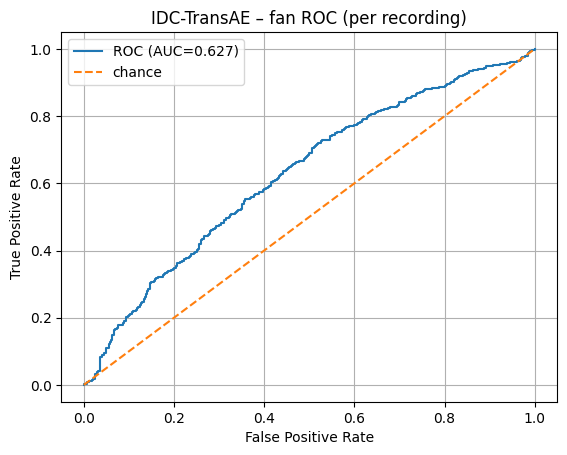

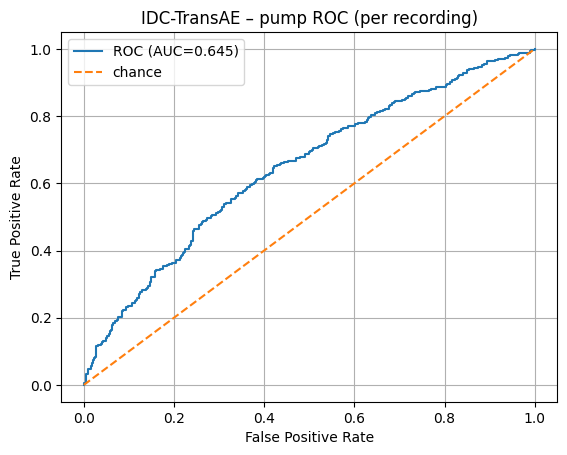

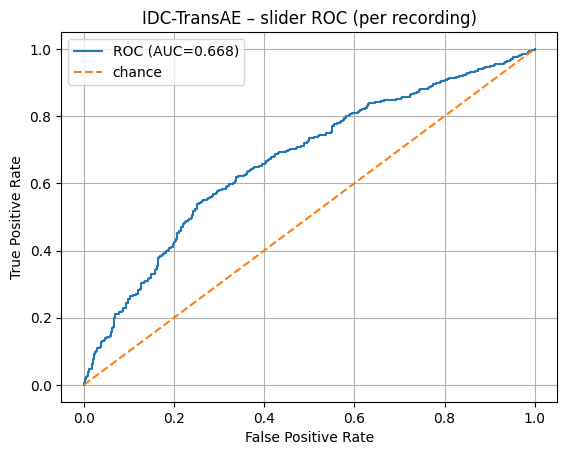

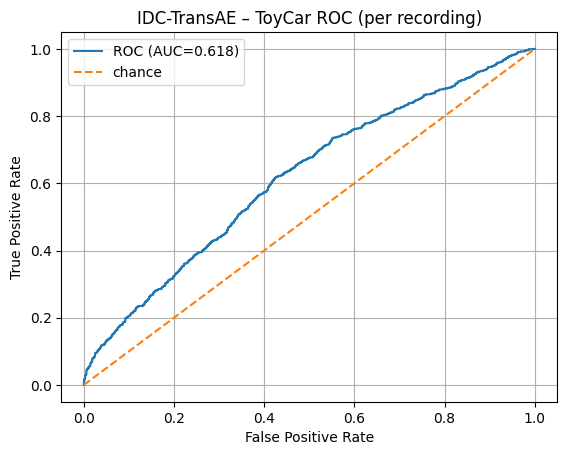

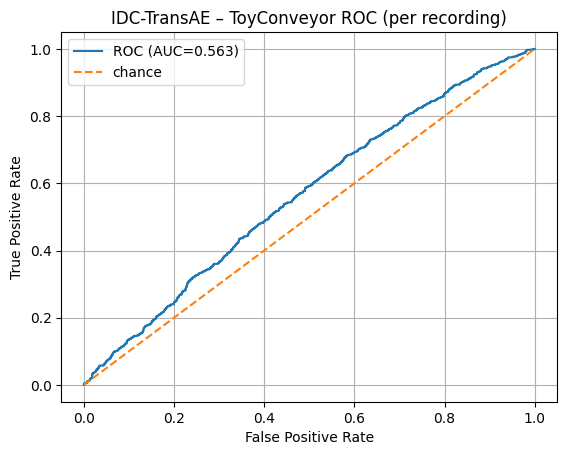

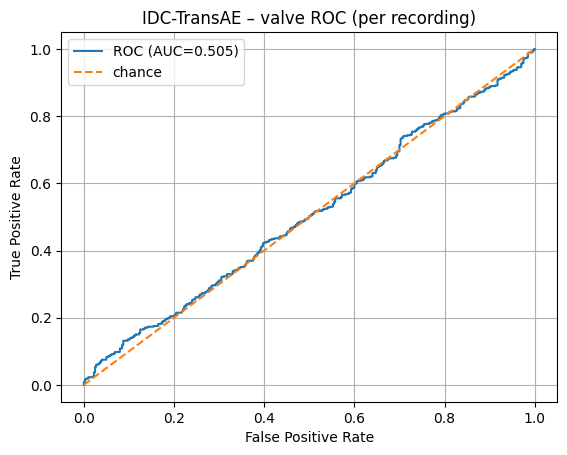

In [24]:
for mtype, res in all_results.items():
    scores = res["scores"]
    labels = res["labels"]

    fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
    auc = res["auc"]

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", label="chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"IDC-TransAE – {mtype} ROC (per recording)")
    plt.legend()
    plt.grid(True)
    plt.show()

### Analyzing a single file with IDC-TransAE

This helper function takes **one audio file** and lets us see *where* in time the model reconstructs well or poorly.

For a given `.wav` file it:

1. **Computes the log-Mel spectrogram**  
   This gives us `spec` with shape `(n_mels, n_frames)`.

2. **Cuts the spectrogram into overlapping patches**  
   Each patch covers a short time window. There is no randomness here: we slide a fixed window over the whole file.

3. **Runs all patches through the IDC-TransAE**  
   For every patch, the model predicts the **center frame** (one Mel column).  
   These predicted center frames are stacked into `recon_center_np`, which forms a “reconstructed spectrogram” at the center positions of each patch.

4. **Aligns predictions with the original spectrogram**  
   We compute the exact time indices of each center frame (`center_indices`) and collect the corresponding true frames from the original spectrogram (`recon_targets`).

5. **Builds an error map**  
   The absolute difference between true and reconstructed center frames is stored in `error_map` with shape `(n_mels, n_centers)`.

The function returns:
- `spec` – full original log-Mel spectrogram  
- `recon_center_np` – reconstructed center-frame spectrogram  
- `center_indices` – time positions of those center frames  
- `error_map` – where and how strongly the model disagrees with the original spectrogram

We use these outputs later to make visual plots of:
- original spectrogram  
- reconstructed spectrogram  
- error map over time


In [37]:
def analyze_single_file_idc(model, path, machine_id, device):
    """
    For a given audio file:
      - compute log-Mel spectrogram
      - extract patches (no randomness)
      - get center-frame reconstruction for each patch
      - build a reconstructed spectrogram on the center-frame positions
      - compute an error map

    Returns:
      spec           : (n_mels, n_frames)
      recon_spec     : (n_mels, n_centers)   [center-frame positions only]
      center_indices : list of time indices (frame indices) for each center
      error_map      : (n_mels, n_centers)   absolute error
    """
    model.eval()

    audio, sr = load_audio(path)
    spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)          # (n_mels, n_frames)

    patches = spec_to_patches(
        spec,
        patch_frames=PATCH_FRAMES,
        patch_hop=PATCH_HOP,
    )  # (n_patches, n_mels, patch_frames)

    if patches.shape[0] == 0:
        raise ValueError("No patches extracted from this file.")

    # Convert to torch tensor batch: (B, 1, n_mels, T)
    patch_tensor = torch.from_numpy(patches).float().unsqueeze(1).to(device)

    B, _, n_mels, T = patch_tensor.shape
    center_idx = get_center_index(T)

    machine_ids = torch.full(
        (B,),
        fill_value=machine_id,
        dtype=torch.long,
        device=device,
    )

    with torch.no_grad():
        recon_center, _, _ = model(
            patch_tensor,
            machine_ids,
            return_patch_errors=True,
        )  # recon_center: (B, n_mels)

    recon_center_np = recon_center.cpu().numpy().T  # (n_mels, B)

    # Target (true) center frames from original spec:
    # we need the time indices of the centers for each patch
    center_indices = []
    recon_targets = []

    n_mels, n_frames = spec.shape
    for i in range(B):
        start = i * PATCH_HOP
        c = start + center_idx
        if c >= n_frames:
            break
        center_indices.append(c)
        recon_targets.append(spec[:, c])

    recon_targets = np.stack(recon_targets, axis=1)  # (n_mels, len(center_indices))
    recon_center_np = recon_center_np[:, : len(center_indices)]

    error_map = np.abs(recon_targets - recon_center_np)  # (n_mels, len(center_indices))

    return spec, recon_center_np, center_indices, error_map

### Reconstruction Helper

This helper function takes a single `.wav` file and gives a **full qualitative analysis** with the IDC-TransAE:

- It loads the audio and converts it to a log-Mel spectrogram.
- It cuts the spectrogram into overlapping patches and lets the model reconstruct the **center frame of every patch**.
- From those predictions it builds:
  - a reconstructed center-frame spectrogram,
  - an error map `|orig − recon|`,
  - an anomaly score curve over time (MSE per patch).
- Finally, it uses Griffin–Lim to turn the original Mel, the reconstructed Mel and the error Mel back into waveforms, so you can **listen to**:
  - the original audio,
  - the reconstructed audio,
  - and the “error” audio (what the model could not explain).

This function is mainly for **visual and auditory inspection**: it helps you see and hear what the model is doing on a single recording.

In [ ]:
from IPython.display import Audio, display
import os

def analyze_idc_full_reconstruction_from_wav(
    wav_path,
    model,
    device,
    feature_fn,        # audio_to_logmelspec
    machine_id,        # dummy ID for unknown sounds
    patch_frames=PATCH_FRAMES,
    patch_hop=PATCH_HOP,
    mean_=0.0,
    std_=1.0,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_iter=32,
):
    """
    Fully analyze a WAV file with IDC-TransAE:

    - Load audio
    - Compute log-Mel spectrogram
    - Extract all patches (no randomness)
    - Reconstruct the center-frame of every patch
    - Build a reconstructed center-frame spectrogram
    - Build an error map
    - Plot:
        * original spectrogram
        * reconstructed center-frame spectrogram
        * error map
        * anomaly score curve over time
    - Playback:
        * original audio
        * reconstructed audio (from reconstructed Mel)
        * error audio (from Mel difference)

    Audio reconstructed from Mel is approximate (Griffin-Lim).
    """

    # 1) Load audio and spectrogram
    audio, sr = load_audio(wav_path)
    spec = feature_fn(audio, sr, n_mels=N_MELS)   # log-Mel, shape (n_mels, n_frames)
    n_mels, n_frames = spec.shape

    # 2) Extract patches
    patches = spec_to_patches(spec, patch_frames=patch_frames, patch_hop=patch_hop)
    if patches.shape[0] == 0:
        raise ValueError("Audio too short to extract patches")

    num_patches = patches.shape[0]

    # Normalize patches for model
    norm_patches = (patches - mean_) / (std_ + 1e-8)
    patch_tensor = torch.from_numpy(norm_patches).float().unsqueeze(1).to(device)
    # (num_patches, 1, n_mels, patch_frames)

    T = patch_frames
    center_idx = get_center_index(T)

    machine_ids = torch.full(
        (num_patches,),
        fill_value=machine_id,
        dtype=torch.long,
        device=device,
    )

    # 3) Run model
    model.eval()
    with torch.no_grad():
        recon_center_norm, _, patch_errors = model(
            patch_tensor,
            machine_ids,
            return_patch_errors=True,
        )

    patch_errors = patch_errors.cpu().numpy()          # (num_patches,)
    recon_center = recon_center_norm.cpu().numpy()     # (num_patches, n_mels)
    recon_center = recon_center * std_ + mean_         # back to log-Mel domain

    # 4) Map patches → echte tijdindex van center-frame
    center_indices = []
    true_centers = []

    for i in range(num_patches):
        start = i * patch_hop
        c = start + center_idx
        if c >= n_frames:
            break
        center_indices.append(c)
        true_centers.append(spec[:, c])

    center_indices = np.array(center_indices)
    true_centers = np.stack(true_centers, axis=1)          # (n_mels, N)
    recon_spec = recon_center[: len(center_indices)].T     # (n_mels, N)
    error_map = np.abs(true_centers - recon_spec)          # (n_mels, N)

    # 5) Tijd-assen
    time_all = np.arange(n_frames) * hop_length / SAMPLE_RATE
    time_centers = center_indices * hop_length / SAMPLE_RATE

    # 6) Plots
    filename = os.path.basename(wav_path)
    plt.figure(figsize=(14, 12))
    plt.suptitle(f"File: {filename}", fontsize=14, y=1.02)

    plt.subplot(4, 1, 1)
    plt.title("Original log-Mel spectrogram")
    plt.imshow(spec, origin="lower", aspect="auto")
    plt.colorbar(label="log-mel")
    plt.ylabel("Mel bin")

    plt.subplot(4, 1, 2)
    plt.title("Reconstructed center-frame spectrogram (IDC-TransAE)")
    plt.imshow(recon_spec, origin="lower", aspect="auto")
    plt.colorbar(label="recon log-mel")
    plt.ylabel("Mel bin")

    plt.subplot(4, 1, 3)
    plt.title("Error map |orig - recon| (center frames)")
    plt.imshow(error_map, origin="lower", aspect="auto")
    plt.colorbar(label="absolute error")
    plt.ylabel("Mel bin")

    plt.subplot(4, 1, 4)
    plt.title("Anomaly score (patch reconstruction error) over time")
    plt.plot(time_centers, patch_errors[: len(time_centers)], label="patch error")
    plt.xlabel("Time (s)")
    plt.ylabel("MSE error")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 7) Audio reconstructie uit Mel

    # Volledige originele Mel (power)
    S_orig = np.exp(spec)

    # Start van gereconstrueerde Mel: kopie van origineel,
    # maar met center-frames vervangen door gereconstrueerde frames
    S_recon = S_orig.copy()
    S_recon[:, center_indices] = np.exp(recon_spec)

    # Error-Mel (verschil in power)
    S_err = np.abs(S_orig - S_recon)

    def mel_to_audio(S_mel):
        return librosa.feature.inverse.mel_to_audio(
            S_mel,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_iter=n_iter,
            power=2.0,
        )

    y_orig = audio                         # originele waveform
    y_recon = mel_to_audio(S_recon)        # gereconstrueerde audio
    y_err = mel_to_audio(S_err)            # “error”-audio

    print("Audio playback (approximate reconstructions from Mel):")

    print("• Original audio")
    display(Audio(y_orig, rate=sr))

    print("• Reconstructed audio (from IDC-TransAE center-frames)")
    display(Audio(y_recon, rate=sr))

    print("• Error audio (difference between original and reconstruction)")
    display(Audio(y_err, rate=sr))

    return spec, recon_spec, error_map, time_centers, patch_errors

# Out of Domain Sound-Test (Elephant)

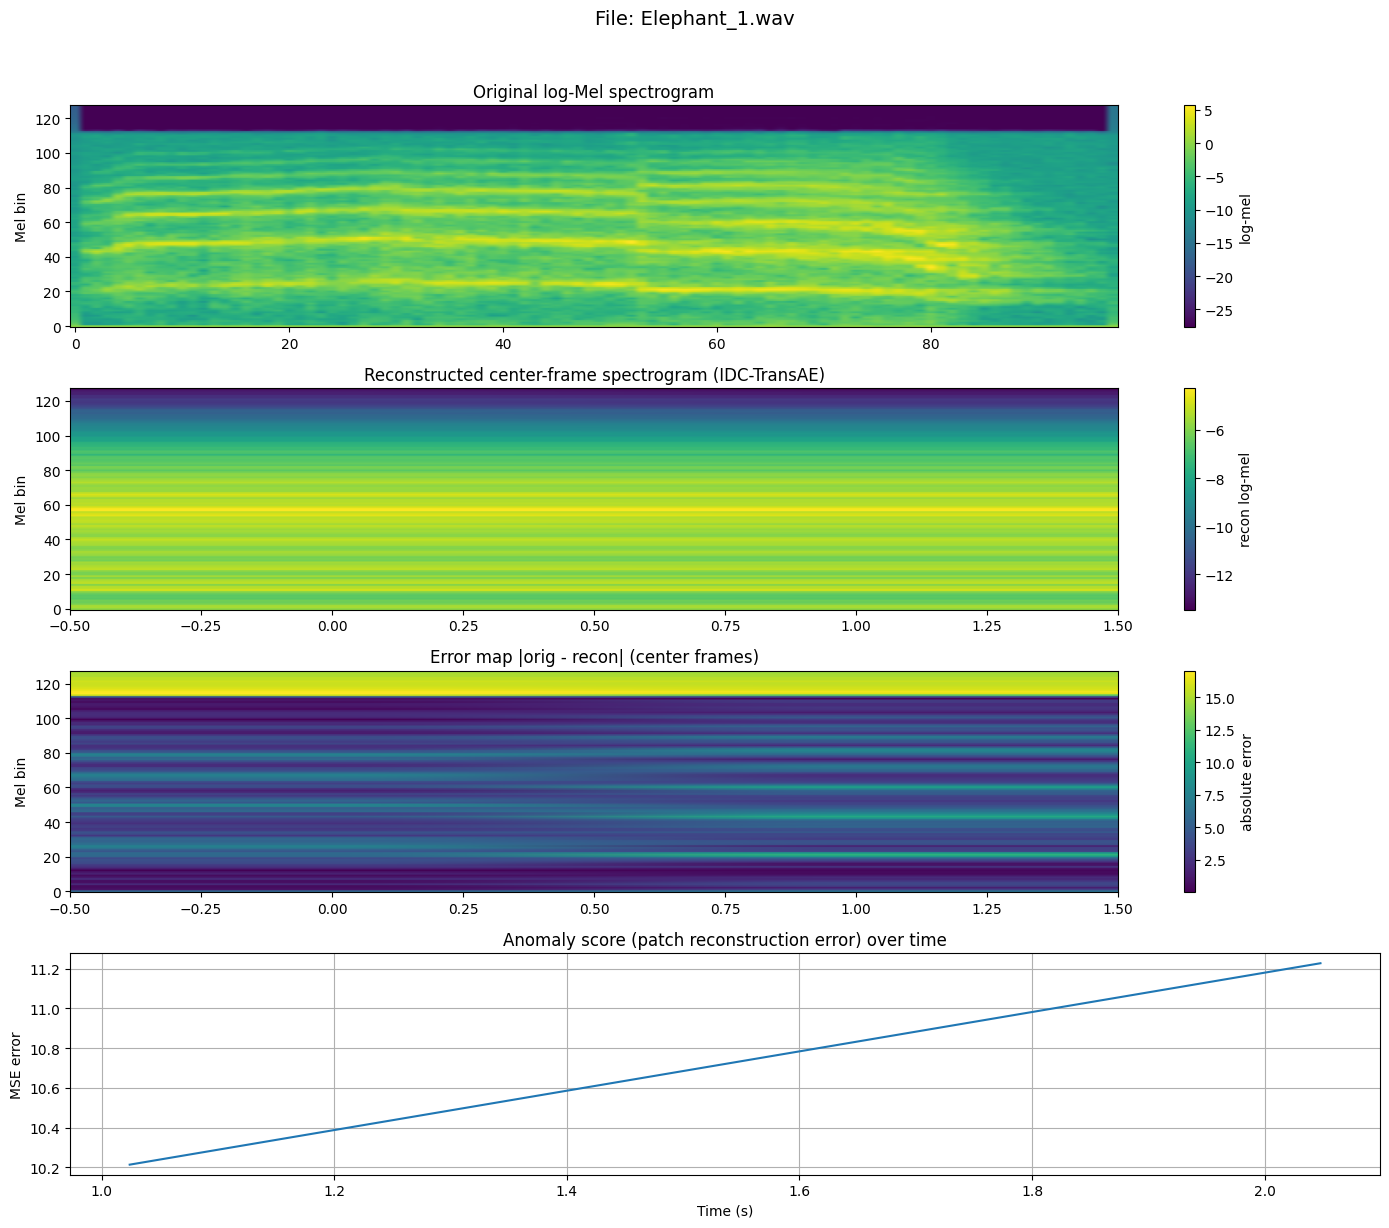

Audio playback (approximate reconstructions from Mel):
• Original audio


• Reconstructed audio (from IDC-TransAE center-frames)


• Error audio (difference between original and reconstruction)


In [39]:
spec, recon_spec, error_map, times, errors = analyze_idc_full_reconstruction_from_wav(
    wav_path="test_sounds/animal_sounds/Elephant/Elephant_1.wav",
    model=idc_model,
    device=device,
    feature_fn=audio_to_logmelspec,
    machine_id=0,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

#### 1. Out-of-domain sound - *Elephant_1.wav*

- The original spectrogram has a clear, slowly changing harmonic structure typical for a vocalisation, not for a rotating machine.
- The reconstructed spectrogram looks like a smoothed, “average fan” pattern: mostly horizontal bands with little time variation.
- The error map is strong across almost the whole time–frequency plane.
- The anomaly score curve is at a **much higher scale** than for fan recordings and increases slightly over time.

**Interpretation:**  
For an elephant sound, the model fails to reproduce the detailed structure and treats almost everything as “unexpected fan behaviour”. As a result, the reconstruction error is consistently high. This confirms that the IDC-TransAE reacts strongly to sounds that are far outside the fan domain.

# Anomaly Fan-Sound Test

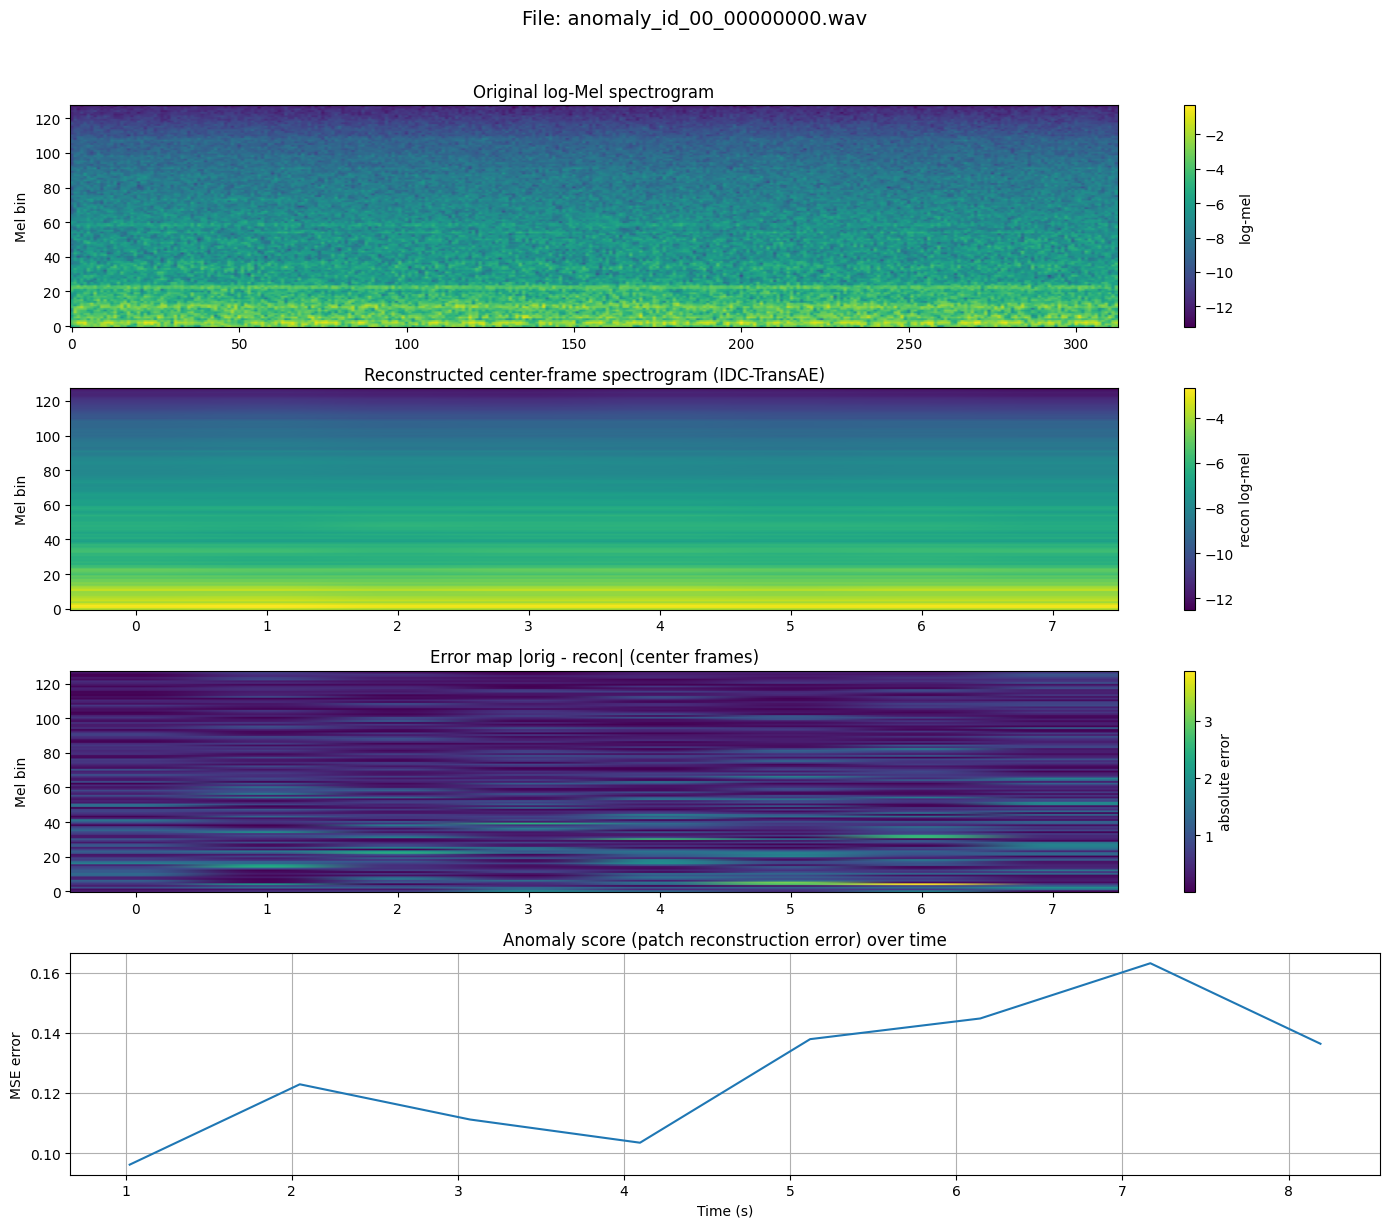

Audio playback (approximate reconstructions from Mel):
• Original audio


• Reconstructed audio (from IDC-TransAE center-frames)


• Error audio (difference between original and reconstruction)


In [40]:
spec, recon_spec, error_map, times, errors = analyze_idc_full_reconstruction_from_wav(
    wav_path="../data/fan/test/anomaly_id_00_00000000.wav",
    model=idc_model,
    device=device,
    feature_fn=audio_to_logmelspec,
    machine_id=0,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

#### 2. Fan test recording - *anomaly_id_00_00000000.wav*

- The original spectrogram looks like a typical noisy fan: broadband energy with stronger low-frequency bands.
- The reconstructed spectrogram again shows a smooth, stationary fan-like pattern.
- The error map shows moderate errors spread over the spectrum, with slightly stronger regions where the original deviates more from the smooth template.
- The anomaly score curve fluctuates between roughly **0.09 and 0.16** over time.

**Interpretation:**  
The model reconstructs this anomalous fan recording reasonably well, with some local increases in error. The anomaly scores are somewhat elevated but still in the same range as normal fans. This matches the global metrics: the model sees many anomalies as only slightly more “difficult” than normal, which makes them hard to separate.

# Normal Fan-Sound Test

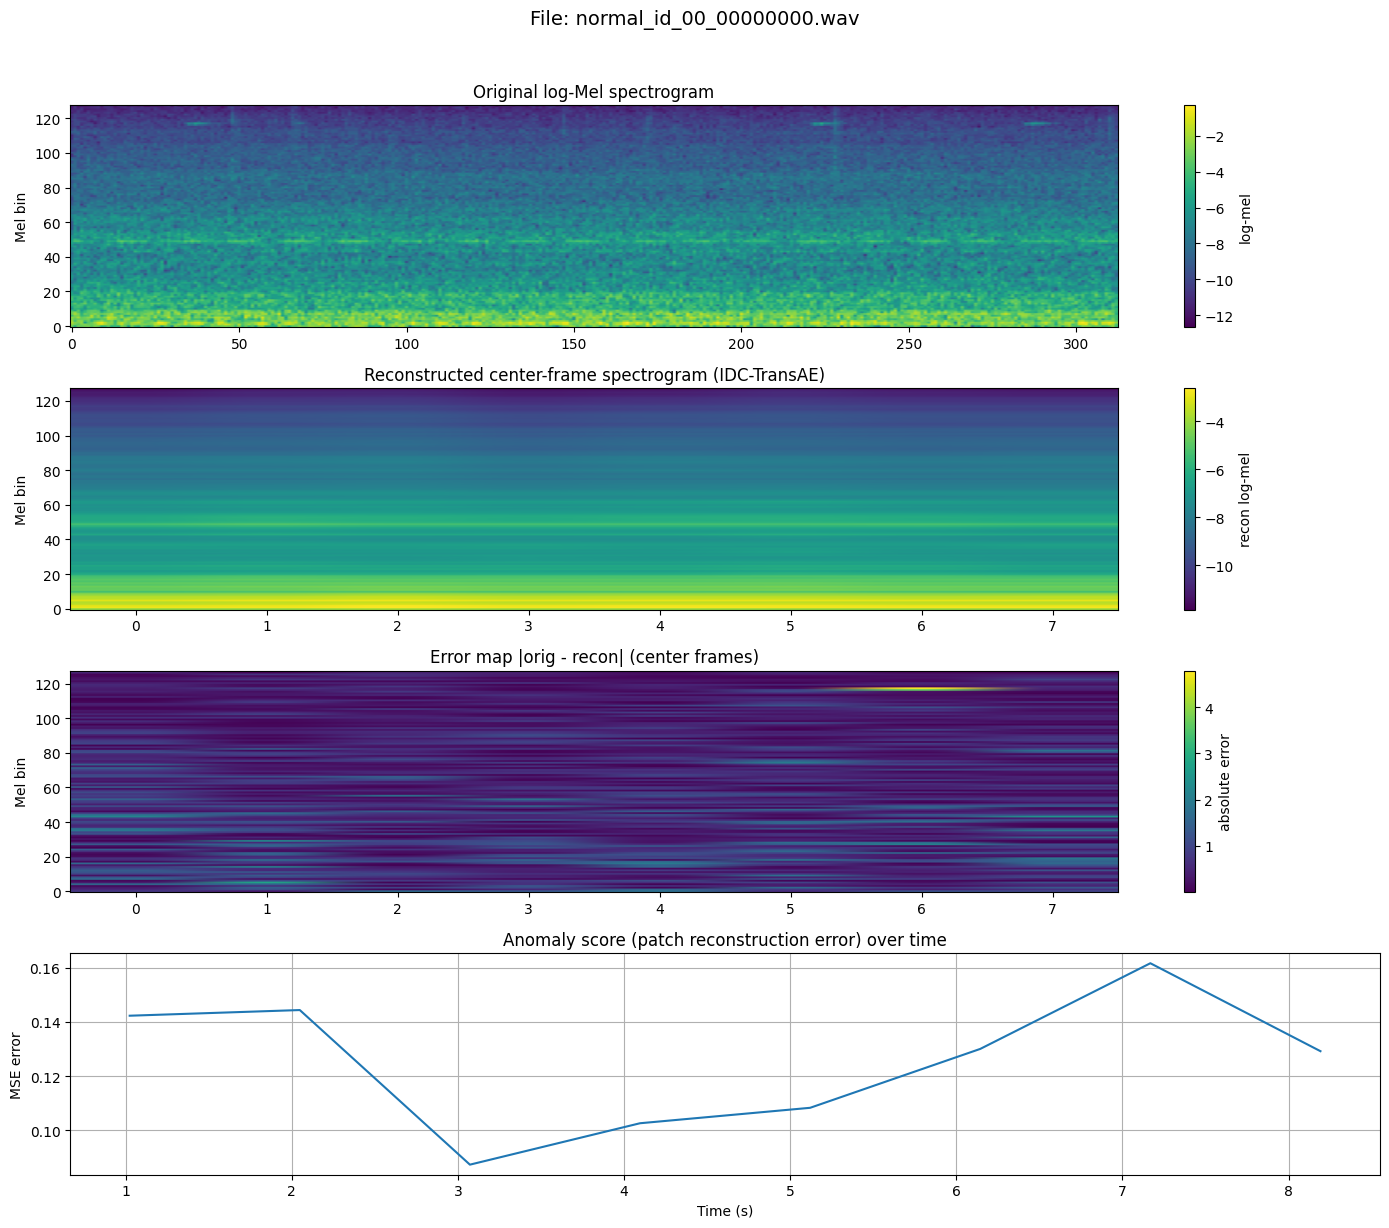

Audio playback (approximate reconstructions from Mel):
• Original audio


• Reconstructed audio (from IDC-TransAE center-frames)


• Error audio (difference between original and reconstruction)


In [30]:
spec, recon_spec, error_map, times, errors = analyze_idc_full_reconstruction_from_wav(
    wav_path="../data/fan/test/normal_id_00_00000000.wav",
    model=idc_model,
    device=device,
    feature_fn=audio_to_logmelspec,
    machine_id=0,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

#### 3. Fan test recording - *normal_id_00_00000000.wav*

- The original spectrogram is again fan-like and quite similar to the anomalous example.
- The reconstructed spectrogram has almost the same smooth fan template as above.
- The error map looks visually very similar to the anomaly case: small to medium errors across the spectrogram.
- The anomaly score curve also moves in the **0.09–0.15** range with a similar shape.

**Interpretation:**  
For this normal recording, the model’s reconstruction behaviour is very close to the anomalous case. The error patterns and the score curve overlap strongly. This illustrates why the ROC-AUC is low: **normal and anomalous fan recordings produce very similar reconstruction errors**, so a single threshold cannot cleanly separate them.

---

Overall, these three examples show:

- **Out-of-domain sounds** (elephant) are clearly “strange” for the model → very large errors.  
- **Within-domain sounds** (normal vs anomalous fan) look very similar to the model → overlapping errors and weak anomaly discrimination.


### Conclusion

In this notebook we explored **ID-conditioned Transformer Autoencoders (IDC-TransAE)** for unsupervised machine-sound anomaly detection using the **DCASE 2020 Task 2 dataset**.  
The goal was to learn a model that understands *normal fan behaviour* and flags deviations through reconstruction error.

We followed these steps:

- We loaded the dataset, extracted **log-Mel spectrograms**, and cut them into **overlapping patches**.
- We built an IDC-TransAE model that:
  - masks the center frame of each patch,
  - uses a Transformer encoder to reconstruct that center frame,
  - is conditioned on the **machine ID**, encouraging the model to learn more specific normal patterns.
- We trained the model purely on **normal fan recordings**, validating the reconstruction and ID losses.
- We evaluated the model at the **patch level** and aggregated errors to the **recording level** using weighted pooling.
- We tested the model on:
  - normal fan recordings,
  - anomalous fan recordings,
  - completely out-of-domain audio (elephant vocalisation).

### Findings

- The IDC-TransAE can **strongly distinguish out-of-domain sounds**: the elephant example produced extremely high reconstruction errors and clear deviations in the spectrogram comparison.
- For **fan test data**, however, errors between normal and anomalous recordings were **highly overlapping**.
- This led to low anomaly-detection performance:
  - ROC-AUC ≈ **0.61**
  - At a 95th-percentile normal threshold:
    - Normal recall ≈ **95%** (expected by construction)
    - Anomaly recall ≈ **12%**
- Visual reconstructions confirmed this:  
  both normal and anomalous fans were reconstructed in a very similar way, with nearly identical error patterns.

### Why this happens

Fan anomalies in DCASE 2020 are often **subtle**, and the IDC-TransAE tends to learn a **smooth, averaged template** of fan behaviour.  
Normal and anomalous recordings both fit this template reasonably well, so their reconstruction errors cluster tightly together.  
The model clearly detects *grossly different* sounds, but struggles with *in-domain subtle anomalies*, which is typical for reconstruction-based methods.

### Summary

We successfully implemented and analysed the IDC-TransAE model.  
It demonstrated **strong out-of-domain sensitivity**, but **weak in-domain anomaly discrimination**, aligning with the broader literature that reconstruction-based methods often fail on DCASE’s subtle anomalies.  
The notebook forms a complete and interpretable pipeline for qualitative and quantitative evaluation of reconstruction-based anomaly detection.